In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import os
import numpy as np
from collections import OrderedDict

from numpy import genfromtxt

inputFolder = 'generated_dataset'
weight_folder = 'weights_folder'
fluxes = np.load(os.path.join(inputFolder,'fluxes.npy'))
GE = np.load(os.path.join(inputFolder,'GE.npy'))

In [6]:
palette ="""#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f
#e5c494
#b3b3b3""".split('\n')
palette_12_2 = """#a6cee3
#1f78b4
#b2df8a
#33a02c
#fb9a99
#e31a1c
#fdbf6f
#ff7f00
#cab2d6
#6a3d9a
#ffff99
#b15928
#8dd3c7""".split('\n')
marker_12 = ['o','8','p','*','+','x','^','>','<','v','D','H','.']
c_palplot = {d:(palette_12_2[i],marker_12[i]) for i,d in  enumerate(set([(k[0],k[1]) for k in GE[-2:,:].T]))}
labelsv = {k:"Oxi: %.1f, Glu: %.1f" %(k[0],k[1]) for k in c_palplot.keys()  }

In [7]:
N_genes=GE.shape[0]
N_cells=GE.shape[1]
N_fluxes = fluxes.shape[0]

# Train validation split
n_test=int(N_cells*0.2)

rand=np.arange(N_cells)
np.random.shuffle(rand)
x_train = GE[:,rand[0:(N_cells-n_test)]].astype('float32')
x_test = GE[:,rand[(N_cells-n_test):N_cells]].astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train=np.transpose(x_train)
x_test=np.transpose(x_test)

y_train = fluxes[:,rand[0:(N_cells-n_test)]].astype('float32')
y_test = fluxes[:,rand[(N_cells-n_test):N_cells]].astype('float32')
y_train = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))
y_train=np.transpose(y_train)
y_test=np.transpose(y_test)

## LOAD VAE

In [8]:
import matplotlib.pyplot as plt
# Set a seed for reproducibility
np.random.seed(123456)
from tensorflow import set_random_seed
set_random_seed(654321)

from keras.models import Model
from keras.layers import Dense, Activation, Input, Dropout
import keras.backend as K
from keras import optimizers

In [9]:
#@title Parameters
num_l1 = 2048 #@param {type:"integer"}
num_l2 = 2048 #@param {type:"integer"}
num_l3 = 1024 #@param {type:"integer"}

inputs = Input(shape=(N_genes,),name='ge_input')

layer_1 = Dense(num_l1, activation='relu')(inputs)
layer_2 = Dense(num_l2, activation='relu')(layer_1)
layer_3 = Dense(num_l2, activation='relu')(layer_2)
#
layer_3 = Dense(num_l2, activation='relu')(layer_3)
layer_3 = Dense(num_l2, activation='relu')(layer_3)
#
layer_3 = Dense(num_l3, activation='relu')(layer_3)
predictions = Dense(N_fluxes, activation='linear')(layer_3)

model_fba = Model(inputs=inputs, outputs=predictions)
def myloss(y_true, y_pred):
    return 1.0*K.mean(K.square(y_pred - y_true), axis=-1)
  
model_fba.compile(optimizer ='adagrad',
             loss ='mean_squared_error')
model_fba.summary()
model_fba.load_weights(os.path.join(weight_folder,'FBA_approx.hdf5'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ge_input (InputLayer)        (None, 1369)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              2805760   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
__________

### Get matrix of weights to the biomass

[[ 0.01060812  0.02374837 -0.03518842 ... -0.01409772 -0.0323809
  -0.00506299]
 [-0.00620697  0.01039792 -0.00476763 ... -0.01865214 -0.00131889
   0.00671329]
 [-0.02000207 -0.01545122  0.0317203  ...  0.01815061  0.03728036
   0.04314158]
 ...
 [-0.0179699   0.00981325  0.00242201 ...  0.0271561  -0.00207804
   0.00094186]
 [-0.01387123 -0.00527764 -0.008888   ... -0.00627671  0.00567307
  -0.0092001 ]
 [-0.00992156 -0.00814802  0.0229994  ... -0.00793726  0.0762586
  -0.00569883]]
(1369,)


(array([  6.,  37., 116., 185., 349., 294., 236., 101.,  36.,   9.]),
 array([-6.46536425e-02, -5.17317906e-02, -3.88099387e-02, -2.58880869e-02,
        -1.29662350e-02, -4.43831086e-05,  1.28774688e-02,  2.57993206e-02,
         3.87211725e-02,  5.16430244e-02,  6.45648763e-02]),
 <a list of 10 Patch objects>)

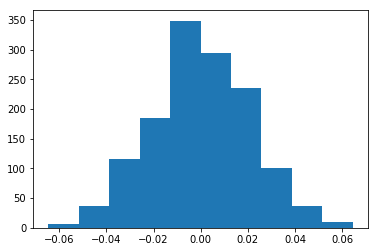

In [11]:
FBA_weights=np.dot(model_fba.layers[-2].get_weights()[0],model_fba.layers[-1].get_weights()[0])
for i in range(3,8):
    FBA_weights=np.dot(model_fba.layers[-i].get_weights()[0],FBA_weights)
        
FBA_weights_biomass=FBA_weights[:,-1] 
print(FBA_weights)
print(FBA_weights_biomass.shape)

plt.hist(FBA_weights_biomass)

## VAE

In [18]:
from scipy.stats import norm
# SEED
np.random.seed(123456)
from tensorflow import set_random_seed
set_random_seed(654321)

from keras.layers import Lambda
from keras import backend as K
from keras import metrics
from keras import metrics

batch_size = 500
latent_dim = 2
epochs = 100
epsilon_std = 1.0
int_size = 1500

x = Input(shape=(N_genes,))
h = Dense(int_size, activation='relu')(x)
h2 = Dense(int_size, activation='relu')(h)
z_mean = Dense(latent_dim)(h2)
z_log_var = Dense(latent_dim)(h2)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(int_size, activation='relu')
decoder_mean = Dense(N_genes, activation='relu')
ge_dense1 = Dense(1024,activation='relu')
ge_dense2 = Dense(2048,activation='relu')
h_decoded = ge_dense2(ge_dense1(decoder_h(z)))
x_decoded_mean = decoder_mean(h_decoded)
output = model_fba(x_decoded_mean)

# instantiate VAE model
autoencoder = Model(inputs=x, outputs=output)
mid_autoencoder = Model(inputs=x, outputs=x_decoded_mean)
# Compute VAE loss
def custom_loss(y_true,y_pred):
    xent_loss = N_genes * metrics.mean_squared_error(y_true, y_pred)
    #xent_loss = metrics.mean_squared_error(y_true, y_pred)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #return K.mean(xent_loss + kl_loss)
    #Beta
    return K.mean(xent_loss + 150.0 * kl_loss)

def mykl(y_true,y_pred):

    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
def mse(y_true,y_pred):
      return metrics.mean_squared_error(y_true, y_pred)
autoencoder.layers[-1].trainable =False
autoencoder.compile(loss = custom_loss, metrics= [mse, mykl], optimizer='adadelta')
autoencoder.summary()
autoencoder.load_weights(os.path.join(weight_folder,'autoencoder.hdf5'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1369)         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1500)         2055000     input_3[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1500)         2251500     dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 2)            3002        dense_25[0][0]                   
__________________________________________________________________________________________________
dense_27 (

In [19]:
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
#_h_decoded = decoder_h(decoder_input)
_h_decoded = ge_dense2(ge_dense1(decoder_h(decoder_input)))
_x_decoded_mean = decoder_mean(_h_decoded)

_fluxes =  model_fba(_x_decoded_mean)
generator = Model(decoder_input, _fluxes)

decoder_ge = Model(decoder_input, _x_decoded_mean)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 1500)              4500      
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              1537024   
_________________________________________________________________
dense_31 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_29 (Dense)             (None, 1369)              2805081   
_________________________________________________________________
model_1 (Model)              (None, 2584)              24337944  
Total params: 30,783,749
Trainable params: 6,445,805
Non-trainable params: 24,337,944
________________________________________________________

## Get weights from Genes' (output of the VAE) to the FBA'

(1369, 2048)
[   5   20   65   77   83   86   92   96  113  118  120  136  137  138
  160  172  181  184  219  220  239  249  253  255  278  296  309  310
  313  315  317  328  339  357  373  383  410  425  432  444  451  470
  474  475  479  497  508  533  565  572  573  578  581  594  603  605
  618  627  652  658  662  670  685  686  689  705  713  726  728  732
  735  749  753  754  761  773  795  803  819  826  828  830  848  849
  850  864  868  871  888  917  919  937  938  939  962  966  968 1006
 1012 1022 1024 1040 1046 1056 1072 1080 1095 1101 1112 1114 1116 1125
 1134 1142 1147 1159 1174 1191 1201 1203 1207 1224 1240 1243 1245 1252
 1261 1263 1274 1289 1307 1316 1318 1345 1365 1367 1368]


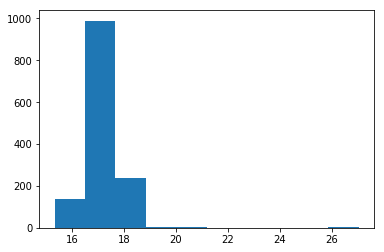

In [20]:
x_decoded_to_FBA_weights=autoencoder.layers[-1].get_weights()[0]

x_decoded_to_FBA_weights2=np.sum(x_decoded_to_FBA_weights*(x_decoded_to_FBA_weights>0),axis=1)

print(x_decoded_to_FBA_weights.shape)
plt.hist(x_decoded_to_FBA_weights2)

#print(x_decoded_to_FBA_weights*(x_decoded_to_FBA_weights>0))

Imp_genes3=np.where(x_decoded_to_FBA_weights2>(np.mean(x_decoded_to_FBA_weights2)+np.std(x_decoded_to_FBA_weights2)))[0]
#Imp_genes_values3=x_decoded_to_FBA_weights2[np.where(x_decoded_to_FBA_weights2>0)[0],-1]
print(Imp_genes3)

2584
mean and std of the weights = 
-1.2731865e-05 0.00053995644
[  23   89  117  138  227  231  235  276  329  343  357  368  384  394
  439  441  563  593  617  618  632  724  735  739  829  846  854  876
  978  990 1040 1042 1120 1135 1297 1304 1332 1361]


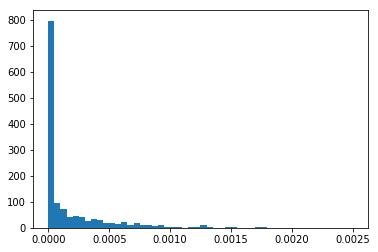

In [21]:
x_decoded_to_FBA_weights=generator.layers[-1].get_weights()[0]
x_decoded_to_FBA_biases=generator.layers[-1].get_weights()[1]

print(N_fluxes)
#weights to biomass
W_last=x_decoded_to_FBA_weights[:,-1]
B_last=x_decoded_to_FBA_biases[-1]


W_last_and_FBA=W_last*FBA_weights_biomass
plt.hist(W_last_and_FBA*(W_last_and_FBA>0),bins=50)

print('mean and std of the weights = ')
print(np.mean(W_last_and_FBA),np.std(W_last_and_FBA))

Imp_genes2=np.where(W_last_and_FBA>2*np.std(W_last_and_FBA))[0]
Imp_genes_values2=x_decoded_to_FBA_weights[np.where(W_last_and_FBA>2*np.std(W_last_and_FBA))[0],-1]


#print(W_last_and_FBA.shape)
print(Imp_genes2)
#print(Imp_genes)

## Pareto Space

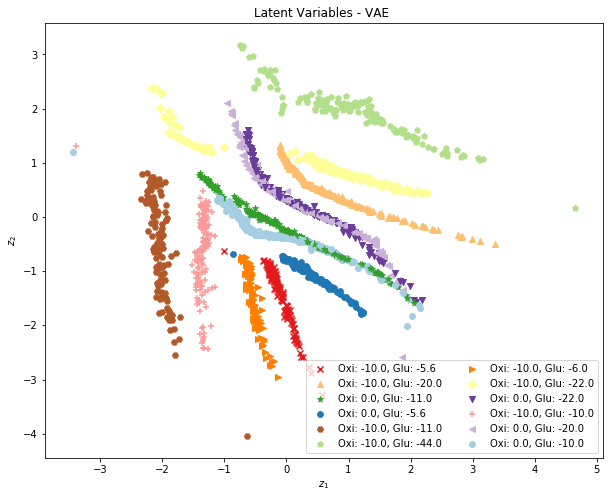

In [23]:
Npoints=GE.shape[1]
GEp= GE.T
encoded = encoder.predict(GE.T[:,:])

subsample = np.random.choice(Npoints,size=min(Npoints,2000),replace=False)
plt.figure(figsize=(10,8))
for k in subsample:
    color,marker = c_palplot[(tuple(GEp[k,-2:]))]
    plt.scatter(encoded[k,0],encoded[k,1],marker=marker,c=color,label=labelsv[tuple(GEp[k,-2:])])
    #save encoded dimensions for each experiment
handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables - VAE ')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(),ncol=2)

## Detect important gene along pareto front

In [24]:
# find the samples in each experiment and their encoded dim

exp1=encoded[np.argwhere((GEp[:,-2]==-10.0)*(GEp[:,-1]==-20.0))[:,0],:]
exp2=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-10))[:,0],:]
exp3=encoded[np.argwhere((GEp[:,-2]==0)*(GEp[:,-1]==-10))[:,0],:]
exp4=encoded[np.argwhere((GEp[:,-2]==0)*(GEp[:,-1]==-5.6))[:,0],:]
exp5=encoded[np.argwhere((GEp[:,-2]==0)*(GEp[:,-1]==-22))[:,0],:]
exp6=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-44))[:,0],:]
exp7=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-11))[:,0],:]
exp8=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-6))[:,0],:]
exp9=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-5.6))[:,0],:]
exp10=encoded[np.argwhere((GEp[:,-2]==-10)*(GEp[:,-1]==-22))[:,0],:]
exp11=encoded[np.argwhere((GEp[:,-2]==0)*(GEp[:,-1]==-20))[:,0],:]
exp12=encoded[np.argwhere((GEp[:,-2]==0)*(GEp[:,-1]==-11))[:,0],:]

EXP=[exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8,exp9,exp10,exp11,exp12]
print(len(EXP))

12


In [25]:
#generate new samples from the encoded dimension along the pareto fronts
N_arti_samples=1000
N_experiments=len(EXP)

X=np.zeros((N_arti_samples,2,12))

for i in range(N_experiments):
    X[:,:,i]=np.random.multivariate_normal((np.mean(EXP[i][:,0]),np.mean(EXP[i][:,1])),
                                            np.cov(EXP[i][:,0],EXP[i][:,1]),N_arti_samples)
                                        
print(X.shape)

#use the decoder to get the gene arrays for the new samples 
X_decoded=np.zeros((N_arti_samples,N_genes,N_experiments))
EXP_decoded=[[]]*N_experiments
#print(len(EXP_decoded))

for i in range(N_experiments):
    X_decoded[:,:,i]=decoder_ge.predict(X[:,:,i])
    EXP_decoded[i]=decoder_ge.predict(EXP[i])

(1000, 2, 12)


In [26]:
########## LOOP FOR ALL EXPERIMENTS ##########
GENES_stable=[[]]*N_experiments
GENES_unstable=[[]]*N_experiments
GENES_stable_real=[[]]*N_experiments
GENES_unstable_real=[[]]*N_experiments

stable_cutoff=1./20.
unstable_cutoff=3

stable_cutoff_r=1./20.
unstable_cutoff_r=3

for i in range(N_experiments):
    #first the ones artificially generated
    genes_mean_dif0=np.where((np.mean(X_decoded[:,:,i],axis=0)!=0)*(np.std(X_decoded[:,:,i],axis=0)!=0))[0] #get the genes with mean&std != 0
    genes_imp_std=np.std(X_decoded[:,genes_mean_dif0,i],axis=0)
    low=np.where(genes_imp_std<(stable_cutoff)*np.std(np.std(X_decoded[:,genes_mean_dif0,i],axis=0)))
    high=np.where(genes_imp_std>unstable_cutoff*np.std(np.std(X_decoded[:,genes_mean_dif0,i],axis=0)))
    GENES_stable[i]=genes_mean_dif0[low]
    GENES_unstable[i]=genes_mean_dif0[high]
    
    #now the ones from the real samples
    real_genes_mean_dif0=np.where((np.mean(EXP_decoded[0],axis=0)!=0)*(np.std(EXP_decoded[0],axis=0)!=0))[0]
    real_genes_imp_std=np.std(EXP_decoded[0][:,real_genes_mean_dif0],axis=0)
    real_low=np.where(real_genes_imp_std<(stable_cutoff_r)*np.std(np.std(EXP_decoded[0][:,real_genes_mean_dif0],axis=0)))
    real_high=np.where(real_genes_imp_std>unstable_cutoff_r*np.std(np.std(EXP_decoded[0][:,real_genes_mean_dif0],axis=0)))
    GENES_stable_real[i]=real_genes_mean_dif0[real_low]
    GENES_unstable_real[i]=real_genes_mean_dif0[real_high]

    
print(GENES_stable_real[0].shape)
print(GENES_stable[0].shape)

(26,)
(27,)


In [27]:
GENES_stable_intersect=[[]]*N_experiments
GENES_unstable_intersect=[[]]*N_experiments


for i in range(N_experiments):
    GENES_stable_intersect[i]=np.intersect1d(GENES_stable[i],GENES_stable_real[i])
    GENES_unstable_intersect[i]=np.intersect1d(GENES_unstable[i],GENES_unstable_real[i])

print(GENES_stable_intersect[0])   

[  55  115 1019]


### Now we compare with the robustness of genes obtained from sensitivity analysis


In [31]:
#from numpy import genfromtxt
robustness = genfromtxt('sensitivity/robustness_-10-10.csv', dtype='float32', delimiter=',')
robustness_exp1=robustness[1:,2:]
robustness = genfromtxt('sensitivity/robustness_-10-20.csv', dtype='float32', delimiter=',')
robustness_exp2=robustness[1:,2:]

In [29]:
import seaborn as sns
sns.set_style('whitegrid')

('#fb9a99', '+')
('#fdbf6f', '^')
{(0.0, -10.0): 'Oxi: 0.0, Glu: -10.0', (0.0, -5.6): 'Oxi: 0.0, Glu: -5.6', (-10.0, -44.0): 'Oxi: -10.0, Glu: -44.0', (0.0, -11.0): 'Oxi: 0.0, Glu: -11.0', (-10.0, -10.0): 'Oxi: -10.0, Glu: -10.0', (-10.0, -5.6): 'Oxi: -10.0, Glu: -5.6', (-10.0, -20.0): 'Oxi: -10.0, Glu: -20.0', (-10.0, -6.0): 'Oxi: -10.0, Glu: -6.0', (0.0, -20.0): 'Oxi: 0.0, Glu: -20.0', (0.0, -22.0): 'Oxi: 0.0, Glu: -22.0', (-10.0, -22.0): 'Oxi: -10.0, Glu: -22.0', (-10.0, -11.0): 'Oxi: -10.0, Glu: -11.0'}
#fdbf6f


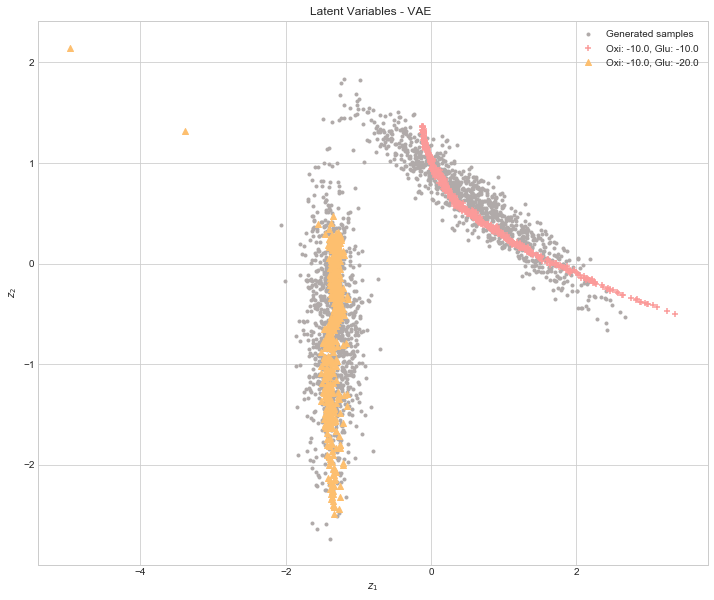

In [30]:
print(c_palplot[(tuple([-10.,-10.]))])
print(c_palplot[(tuple([-10.,-20.]))])
color1,marker1 = c_palplot[(tuple([-10.,-10.]))]
color2,marker2 = c_palplot[(tuple([-10.,-20.]))]
#color3,marker3 = c_palplot[(tuple([20.,20.]))]


plt.figure(figsize=(12,10))
plt.scatter(X[:,0,0],X[:,1,0],marker='.',c='#B0AAA9',label='Generated samples')
plt.scatter(X[:,0,1],X[:,1,1],marker='.',c='#B0AAA9',label='Generated samples')
plt.scatter(EXP[0][:,0],EXP[0][:,1],marker=marker1,c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(EXP[1][:,0],EXP[1][:,1],marker=marker2,c=color2,label='Oxi: -10.0, Glu: -20.0')
handles, labels = plt.gca().get_legend_handles_labels()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Latent Variables - VAE ')
by_label = OrderedDict(zip(labels, handles))
leg = plt.legend(by_label.values(), by_label.keys(),ncol=1)
print(labelsv)
print(color2)

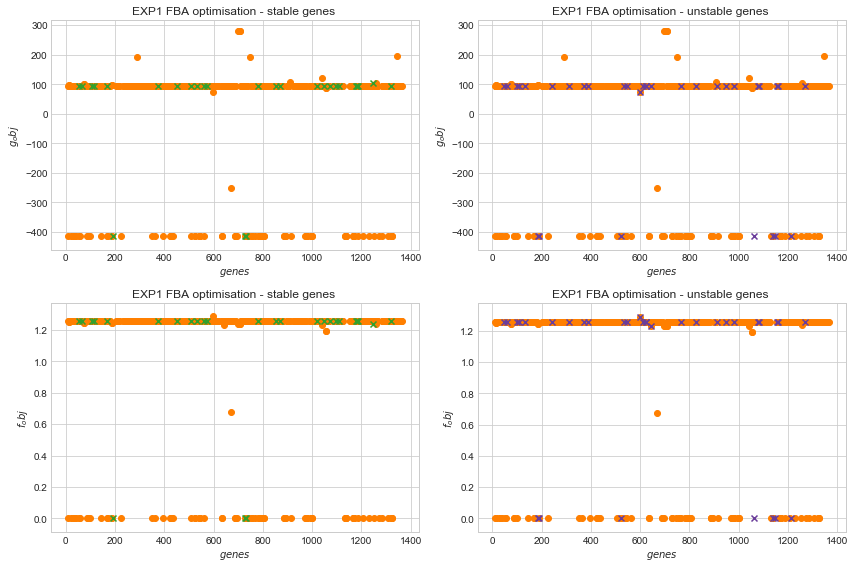

In [35]:
subset = np.random.choice(N_genes,500)
n_sub = 500

color1,_ = c_palplot[(tuple([-10.,-6.]))]
robustness_exp1[3]
plt.figure(figsize=(12,8))
plt.subplot2grid((2, 4), (0, 0), colspan=2)
#plt.scatter(np.arange(N_genes-1),robustness_exp1[:,1],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(subset,robustness_exp1[subset,1],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(GENES_stable[0],robustness_exp1[GENES_stable[0],1],marker='x',c=palette_12_2[3],label='Stable genes')
plt.xlabel(r'$genes$')
plt.ylabel(r'$g_obj$')
plt.title('EXP1 FBA optimisation - stable genes ')


plt.subplot2grid((2, 4), (0, 2), colspan=2)
plt.scatter(subset,robustness_exp1[subset,1],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
#plt.scatter(np.arange(N_genes-1),robustness_exp1[:,1],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(GENES_unstable[0],robustness_exp1[GENES_unstable[0],1],marker='x',c=palette_12_2[9],label='Unstable genes')
plt.xlabel(r'$genes$')
plt.ylabel(r'$g_obj$')
plt.title('EXP1 FBA optimisation - unstable genes ')

plt.subplot2grid((2, 4), (1, 0), colspan=2)
plt.scatter(subset,robustness_exp1[subset,0],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')

#plt.scatter(np.arange(N_genes-1),robustness_exp1[:,0],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(GENES_stable[0],robustness_exp1[GENES_stable[0],0],marker='x',c=palette_12_2[3],label='Stable genes')
plt.xlabel(r'$genes$')
plt.ylabel(r'$f_obj$')
plt.title('EXP1 FBA optimisation - stable genes ')


plt.subplot2grid((2, 4), (1, 2), colspan=2)
plt.scatter(subset,robustness_exp1[subset,0],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')

#plt.scatter(np.arange(N_genes-1),robustness_exp1[:,0],marker='o',c=color1,label='Oxi: -10.0, Glu: -10.0')
plt.scatter(GENES_unstable[0],robustness_exp1[GENES_unstable[0],0],marker='x',c=palette_12_2[9],label='Unstable genes')
plt.xlabel(r'$genes$')
plt.ylabel(r'$f_obj$')
plt.title('EXP1 FBA optimisation - unstable genes ')
plt.tight_layout()
#plt.savefig('genes.pdf',format='pdf')